In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
%matplotlib inline

ImportError: Traceback (most recent call last):
  File "C:\Users\xwang\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 18, in swig_import_helper
    fp, pathname, description = imp.find_module('_pywrap_tensorflow_internal', [dirname(__file__)])
  File "C:\Users\xwang\anaconda3\lib\imp.py", line 296, in find_module
    raise ImportError(_ERR_MSG.format(name), name=name)
ImportError: No module named '_pywrap_tensorflow_internal'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\xwang\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\xwang\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\xwang\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 20, in swig_import_helper
    import _pywrap_tensorflow_internal
ModuleNotFoundError: No module named '_pywrap_tensorflow_internal'


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
pip uninstall tensorflow

In [ ]:
install tensorflow

In [2]:
df = pd.read_csv("df_with_gcs_random_num.txt",sep=',',header=0)

In [3]:
#划分训练测试集
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.1, random_state=42)

处理词向量

In [4]:
from gensim.models import word2vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 

In [5]:
# 切分词汇
def cut(data):
    cut= [s.split() for s in data['TriageNote'].astype(str)]
    return cut

In [6]:
train_text=cut(train_set)
test_text=cut(test_set)
sentences=train_text+test_text

In [7]:
#得到最大句子长度
num_list=[len(one) for one in sentences]
max(num_list)

57

In [8]:
maxLen=64

In [9]:
#处理label->one_hot
from sklearn.preprocessing import LabelEncoder

def encodelabel(data):
    le = LabelEncoder()
    resultLable=le.fit_transform(data['DISPOSITION'])
    return resultLable


In [10]:
train_lable=encodelabel(train_set)
test_lable=encodelabel(test_set)

In [11]:
wvmodel = word2vec.Word2Vec.load("./word2vec/word2vec_all.model")

2022-09-26 14:41:38,467 : INFO : loading Word2Vec object from ./word2vec/word2vec_all.model
2022-09-26 14:41:38,478 : INFO : loading wv recursively from ./word2vec/word2vec_all.model.wv.* with mmap=None
2022-09-26 14:41:38,478 : INFO : setting ignored attribute cum_table to None
2022-09-26 14:41:38,599 : INFO : Word2Vec lifecycle event {'fname': './word2vec/word2vec_all.model', 'datetime': '2022-09-26T14:41:38.599599', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'loaded'}


In [12]:
nekg=np.load('nekg 1-999 100d.npy')

In [13]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab = tokenizer.word_index 

In [14]:
#特征数字编号，不足的话会在前面补充0
trainID = tokenizer.texts_to_sequences(train_text)
# print(trainID)
testID = tokenizer.texts_to_sequences(test_text)
trainSeq=pad_sequences(trainID,maxlen=maxLen)
#print(trainSeq)
testSeq=pad_sequences(testID,maxlen=maxLen)

#标签的独热编码
trainCate = to_categorical(train_lable, num_classes=2)  # 将标签转换为one-hot编码
#print(trainCate)
testCate= to_categorical(test_lable, num_classes=2)  # 将标签转换为one-hot编码

In [ ]:
def nekg_embed(n0):
    n1=int(n0)
    n2=int(n0)+1
    s1=(n2-n0)/(n2-n1)
    s2=(n0-n1)/(n2-n1)
    return s1*nekg[n1]+s2*nekg[n2]

In [15]:
#利用训练后的word2vec自定义Embedding的训练矩阵，每行代表一个词（结合独热码和矩阵乘法理解）
embedding_matrix = np.zeros((len(vocab) + 1, 100))
for word, i in vocab.items():
    try:
        if(word.isdigit()==False):#对word用word2vec
            embedding_vector = wvmodel.wv[str(word)]
        else:#对number用nekg
            if (int(float(word))<=998):
                embedding_vector =  nekg_embed(float(word))
            else:
                embedding_vector = wvmodel.wv[str(word)]
        embedding_matrix[i] = embedding_vector    
    except KeyError:
        continue

In [16]:
## 定义LSTM模型
batch_size=256
inputs = Input(name='inputs',shape=[maxLen])
embedder = Embedding(len(vocab) + 1, 100, input_length=maxLen, weights=[embedding_matrix], trainable=True)
model=Sequential()
model.add(embedder)
model.add(LSTM(64))
model.add(Dense(64,activation="sigmoid",name="FC1"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax",name="FC2"))
model.summary()
model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])
#reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1 ,patience=3, mode='auto')
history=model.fit(trainSeq, trainCate, batch_size, epochs=30,validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=5)])
model.save("LSTM")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 100)           775100    
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 FC1 (Dense)                 (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 FC2 (Dense)                 (None, 2)                 130       
                                                                 
Total params: 821,630
Trainable params: 821,630
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 

2022-09-26 14:41:50,856 : WARNING : Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: LSTM\assets


2022-09-26 14:41:51,403 : INFO : Assets written to: LSTM\assets


In [17]:
#预测与评估
mainModel = load_model('LSTM')
result = mainModel.predict(testSeq)  # 预测样本属于每个类别的概率
score = mainModel.evaluate(testSeq,
                           testCate,
                           batch_size=32)
print(score)

6/6 [==============================] - 0s 7ms/step - loss: 0.7389 - accuracy: 0.6550
[0.7389013171195984, 0.6549707651138306]


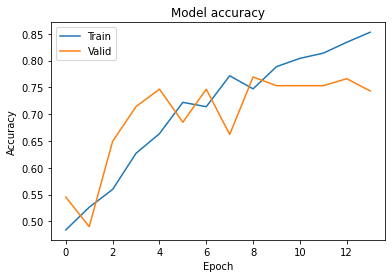

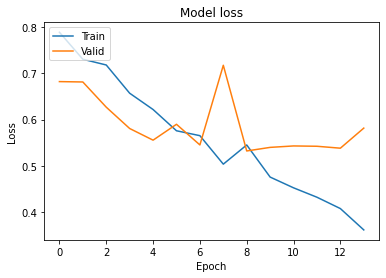

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Valid'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Valid'],loc='upper left')
plt.show()

In [19]:
score_list=[]
for i in range(10):
    ## 定义LSTM模型
    batch_size=256
    inputs = Input(name='inputs',shape=[maxLen])
    embedder = Embedding(len(vocab) + 1, 100, input_length=maxLen, weights=[embedding_matrix], trainable=True)
    model=Sequential()
    model.add(embedder)
    model.add(LSTM(64))
    model.add(Dense(64,activation="sigmoid",name="FC1"))
    model.add(Dropout(0.4,seed=12))
    model.add(Dense(2,activation="softmax",name="FC2"))
    model.summary()
    model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1 ,patience=3, mode='auto')
    history=model.fit(trainSeq, trainCate, batch_size, epochs=30,validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=5)])
    result = model.predict(testSeq)  # 预测样本属于每个类别的概率
    score = model.evaluate(testSeq,
                               testCate,
                               batch_size=32)
    score_list.append(score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 100)           775100    
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 FC1 (Dense)                 (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 FC2 (Dense)                 (None, 2)                 130       
                                                                 
Total params: 821,630
Trainable params: 821,630
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] 

5/5 [==============================] - 1s 118ms/step - loss: 0.3514 - accuracy: 0.8595 - val_loss: 0.5441 - val_accuracy: 0.7597
Epoch 14/30
5/5 [==============================] - 1s 118ms/step - loss: 0.4360 - accuracy: 0.8107 - val_loss: 0.5338 - val_accuracy: 0.7760
Epoch 15/30
6/6 [==============================] - 0s 6ms/step - loss: 0.6645 - accuracy: 0.7018
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 64, 100)           775100    
                                                                 
 lstm_6 (LSTM)               (None, 64)                42240     
                                                                 
 FC1 (Dense)                 (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                 

 FC1 (Dense)                 (None, 64)                4160      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 FC2 (Dense)                 (None, 2)                 130       
                                                                 
Total params: 821,630
Trainable params: 821,630
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 2s 185ms/step - loss: 0.7539 - accuracy: 0.5207 - val_loss: 0.6818 - val_accuracy: 0.5292
Epoch 2/30
5/5 [==============================] - 0s 102ms/step - loss: 0.7193 - accuracy: 0.5670 - val_loss: 0.6523 - val_accuracy: 0.6071
Epoch 3/30
5/5 [==============================] - 1s 108ms/step - loss: 0.7036 - accuracy: 0.5808 - val_loss: 0.6173 - val_accuracy: 0.6591
Epoch 4/30
5/5 [==============================

Epoch 10/30
5/5 [==============================] - 1s 142ms/step - loss: 0.5200 - accuracy: 0.7612 - val_loss: 0.5986 - val_accuracy: 0.6656
Epoch 11/30
5/5 [==============================] - 1s 146ms/step - loss: 0.4635 - accuracy: 0.8034 - val_loss: 0.5344 - val_accuracy: 0.7565
Epoch 12/30
5/5 [==============================] - 1s 147ms/step - loss: 0.5172 - accuracy: 0.7669 - val_loss: 0.5282 - val_accuracy: 0.7468
Epoch 13/30
5/5 [==============================] - 1s 142ms/step - loss: 0.4414 - accuracy: 0.8197 - val_loss: 0.7221 - val_accuracy: 0.6039
Epoch 14/30
5/5 [==============================] - 1s 142ms/step - loss: 0.4368 - accuracy: 0.8123 - val_loss: 0.5228 - val_accuracy: 0.7825
Epoch 15/30
5/5 [==============================] - 1s 145ms/step - loss: 0.4144 - accuracy: 0.8367 - val_loss: 0.5487 - val_accuracy: 0.7565
Epoch 16/30
5/5 [==============================] - 1s 140ms/step - loss: 0.3367 - accuracy: 0.8700 - val_loss: 0.6479 - val_accuracy: 0.6786
Epoch 17/30
5

In [20]:
print('accuracy:'+str(sum(score_list)/len(score_list)))

accuracy:0.6748538017272949


In [21]:
score_list.sort()

In [22]:
score_list

[0.6374269127845764,
 0.6491228342056274,
 0.6549707651138306,
 0.6725146174430847,
 0.6783625483512878,
 0.6783625483512878,
 0.6900584697723389,
 0.6900584697723389,
 0.6959064602851868,
 0.7017543911933899]